In [1]:
from datasets import load_dataset
dataset_train = load_dataset("keremberke/shoe-classification",'full', split='train')

In [2]:
#사전학습 Vision 트랜스포머 불러오기
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTImageProcessor 
from sklearn.neighbors import NearestNeighbors
import torch

# import model - https://huggingface.co/google/vit-base-patch16-224-in21k
model_id = 'google/vit-base-patch16-224-in21k'

model_vanilla = ViTForImageClassification.from_pretrained(model_id)
# feature_extractor_vanilla = ViTFeatureExtractor.from_pretrained(model_id) # will be deprecated
feature_extractor_vanilla = ViTImageProcessor.from_pretrained(model_id)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# model_vanilla # 모델 구조 시각화

In [4]:
# feature_extractor_vanilla # 모델 feature 시각화

In [5]:
model_vanilla.classifier = torch.nn.Identity()

In [6]:
def extract_embeddings(dataset, model, feature_extractor):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for item in dataset:
            inputs = feature_extractor(images=item['image'], return_tensors="pt")
            outputs = model(**inputs)
            embeddings.append(outputs.logits.squeeze().numpy())
    return embeddings

In [7]:
def retrieve_images(index, nn_model, dataset, embeddings):
    index = int(index)
    distances, indices = nn_model.kneighbors([embeddings[index]])

    indexed_distances = [(int(i), dist) for i, dist in zip(indices[0], distances[0]) if i != index]

    indexed_distances.sort(key=lambda x: x[1])

    retrieved_images = [dataset[idx]["image"] for idx, _ in indexed_distances]
    return retrieved_images

def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        img = dataset["train"][i]["image"]
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

In [8]:
embeddings_vanilla = extract_embeddings(dataset_train, model_vanilla, feature_extractor_vanilla)
nn_model_vanilla = NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
nn_model_vanilla.fit(embeddings_vanilla)

NearestNeighbors(algorithm='ball_tree', n_neighbors=6)

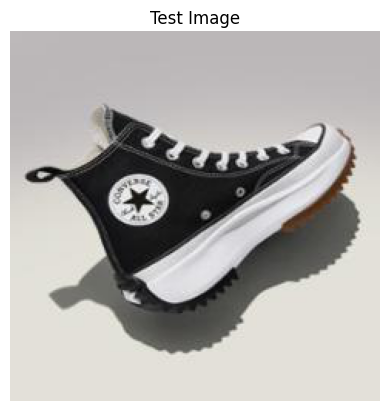

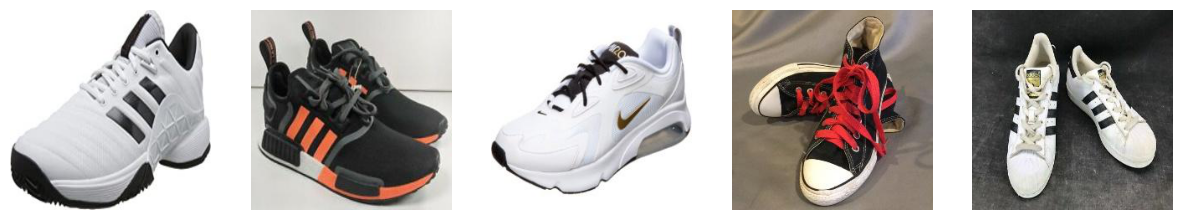

In [9]:
import matplotlib.pyplot as plt
test_index =358
retrieved_images = retrieve_images(test_index, nn_model_vanilla, dataset_train, embeddings_vanilla)

plt.imshow(dataset_train[test_index]["image"])
plt.title("Test Image")
plt.axis('off')
plt.show()

show_images({"train": [{"image": img} for img in retrieved_images]})

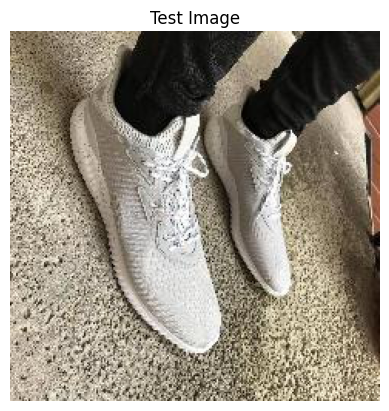

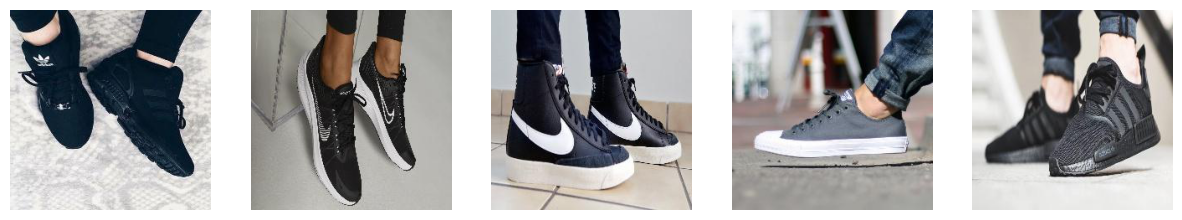

In [10]:
test_index = 65
retrieved_images = retrieve_images(test_index, nn_model_vanilla, dataset_train, embeddings_vanilla)

plt.imshow(dataset_train[test_index]["image"])
plt.title("Test Image")
plt.axis('off')
plt.show()

show_images({"train": [{"image": img} for img in retrieved_images]})

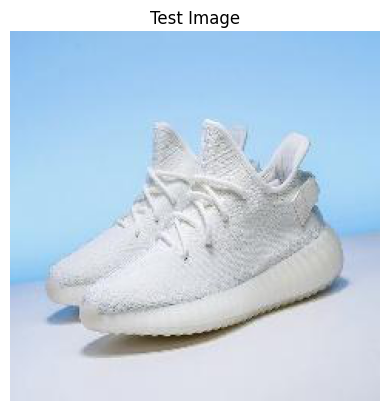

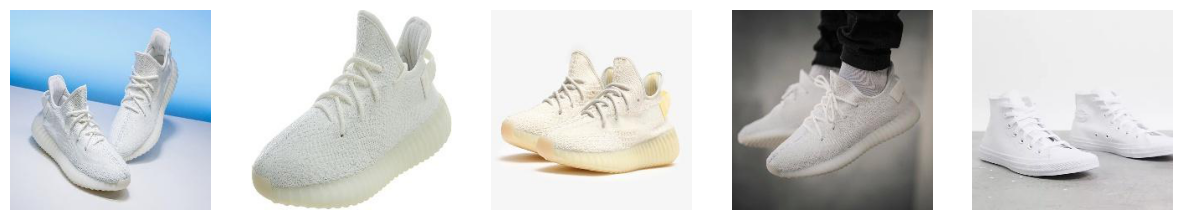

In [11]:
test_index = 94
retrieved_images = retrieve_images(test_index, nn_model_vanilla, dataset_train, embeddings_vanilla)

plt.imshow(dataset_train[test_index]["image"])
plt.title("Test Image")
plt.axis('off')
plt.show()

show_images({"train": [{"image": img} for img in retrieved_images]})

In [12]:
#Fine-Tuning
dataset_test = load_dataset("keremberke/shoe-classification",'full', split='validation')

In [13]:
def preprocess(batch):
    inputs = feature_extractor_vanilla(
        batch['image'],
        return_tensors='pt'
    )
    inputs['labels'] = batch['labels']
    return inputs

In [14]:
train_prepared = dataset_train.with_transform(preprocess)
test_prepared = dataset_test.with_transform(preprocess)

In [15]:
def collate_batch(batch):
    pixel_vals = [item['pixel_values'] for item in batch]
    labels = [item['labels'] for item in batch]
    return {'pixel_values': torch.stack(pixel_vals), 'labels': torch.tensor(labels)}

In [16]:
import numpy as np
import evaluate

accuracy_metric = evaluate.load("accuracy")


def evaluate_model_performance(outputs):
    predicted_labels = np.argmax(outputs.predictions, axis=1)
    true_labels = outputs.label_ids
    return accuracy_metric.compute(predictions=predicted_labels, references=true_labels)

In [17]:
num_labels_in_dataset = len(set(dataset_train['labels']))
label_names = dataset_train.features['labels'].names

num_labels_in_dataset, label_names

(3, ['converse', 'adidas', 'nike'])

In [18]:
model = ViTForImageClassification.from_pretrained(
    model_id,
    num_labels=num_labels_in_dataset
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# model

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [21]:
import transformers
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./shoe",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=10,
  save_steps=20,
  eval_steps=20,
  logging_steps=20,
  learning_rate=0.0002,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  #load_best_model_at_end=True,
)

In [22]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [23]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_batch,
    compute_metrics=evaluate_model_performance,
    train_dataset=train_prepared,
    eval_dataset=test_prepared,
    tokenizer=feature_extractor_vanilla,
)

C:\Users\sckim\.conda\envs\vectordb\Lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [24]:
training_outcome = trainer.train()
trainer.save_model()

training_metrics = training_outcome.metrics
trainer.log_metrics("training", training_metrics)
trainer.save_metrics("training", training_metrics)

trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
20,0.774000,1.292904,0.078313
40,0.416900,1.003604,0.638554
60,0.188800,1.276060,0.542169
80,0.141700,0.612321,0.819277
100,0.058200,0.420489,0.885542
120,0.082800,0.658948,0.819277
140,0.018000,0.934411,0.771084
160,0.013000,0.732366,0.825301
180,0.018600,0.669602,0.837349
200,0.009000,0.792449,0.825301


Checkpoint destination directory ./shoe\checkpoint-20 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./shoe\checkpoint-40 already exists and is non-empty.Saving will proceed but saved results may be invalid.


***** training metrics *****
  epoch                    =        10.0
  total_flos               = 415703152GF
  train_loss               =      0.0985
  train_runtime            =  0:09:48.93
  train_samples_per_second =        9.78
  train_steps_per_second   =       0.611


In [25]:
evaluation_metrics = trainer.evaluate(test_prepared)

trainer.log_metrics("evaluation", evaluation_metrics)
trainer.save_metrics("evaluation", evaluation_metrics)

***** evaluation metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.7892
  eval_loss               =     1.0378
  eval_runtime            = 0:00:06.04
  eval_samples_per_second =     27.455
  eval_steps_per_second   =      3.473


In [26]:
fine_tuned_path = './shoe'
model_finetuned = ViTForImageClassification.from_pretrained(fine_tuned_path)
feature_extractor_finetuned = ViTImageProcessor.from_pretrained(fine_tuned_path)
model_finetuned.classifier = torch.nn.Identity()

embeddings_ft = extract_embeddings(dataset_train, model_finetuned, feature_extractor_finetuned)

nn_model_ft = NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
nn_model_ft.fit(embeddings_ft)

C:\Users\sckim\.conda\envs\vectordb\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


NearestNeighbors(algorithm='ball_tree', n_neighbors=6)

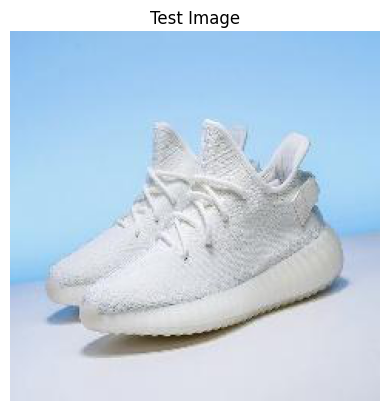

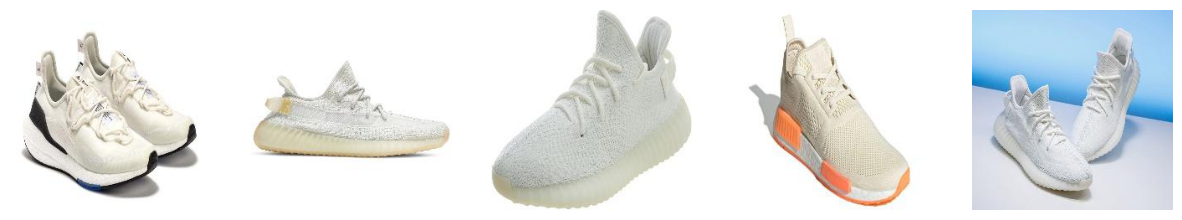

In [27]:
import matplotlib.pyplot as plt
test_index = 94
retrieved_images = retrieve_images(test_index, nn_model_ft, dataset_train,embeddings_ft)
plt.imshow(dataset_train[test_index]["image"])
plt.title("Test Image")
plt.axis('off')
plt.show()

show_images({"train": [{"image": img} for img in retrieved_images]})

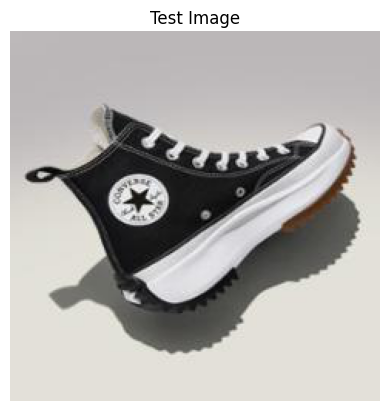

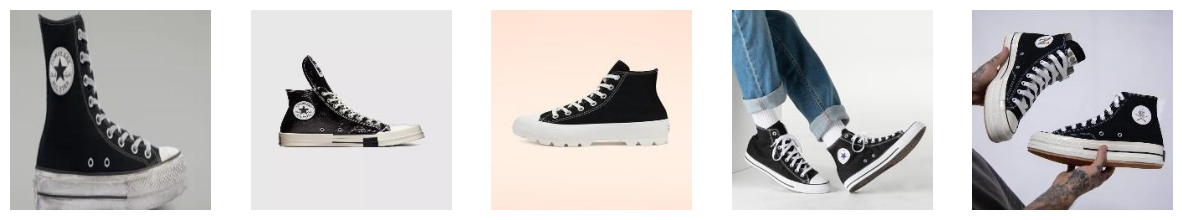

In [28]:
test_index = 358
retrieved_images = retrieve_images(test_index, nn_model_ft, dataset_train,embeddings_ft)
plt.imshow(dataset_train[test_index]["image"])
plt.title("Test Image")
plt.axis('off')
plt.show()

show_images({"train": [{"image": img} for img in retrieved_images]})

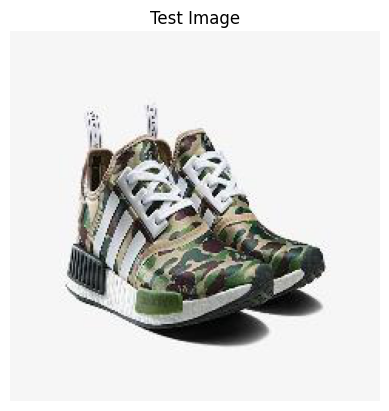

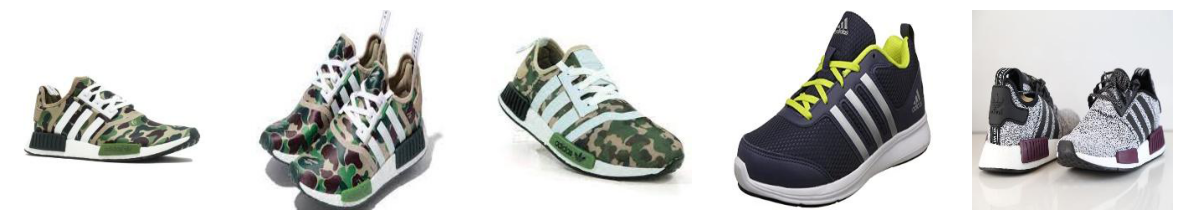

In [29]:
test_index = 174
retrieved_images = retrieve_images(test_index, nn_model_ft, dataset_train,embeddings_ft)
plt.imshow(dataset_train[test_index]["image"])
plt.title("Test Image")
plt.axis('off')
plt.show()

show_images({"train": [{"image": img} for img in retrieved_images]})

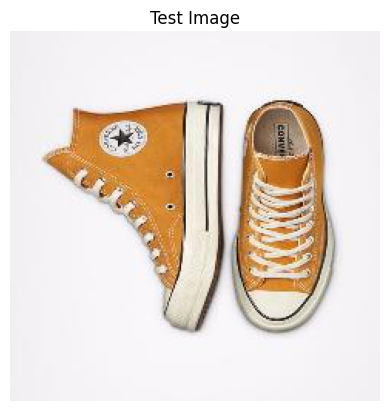

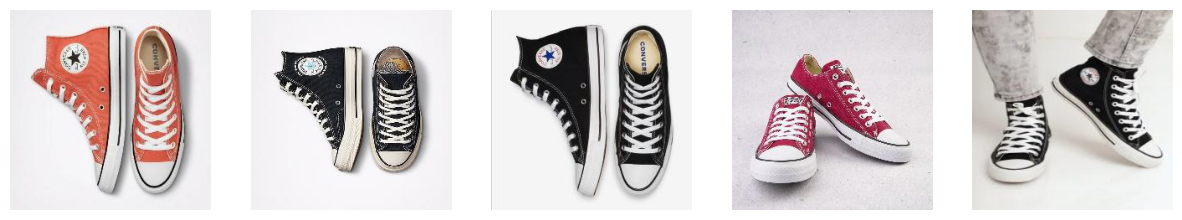

In [30]:
test_index =383
retrieved_images = retrieve_images(test_index, nn_model_ft, dataset_train,embeddings_ft)
plt.imshow(dataset_train[test_index]["image"])
plt.title("Test Image")
plt.axis('off')
plt.show()

show_images({"train": [{"image": img} for img in retrieved_images]})

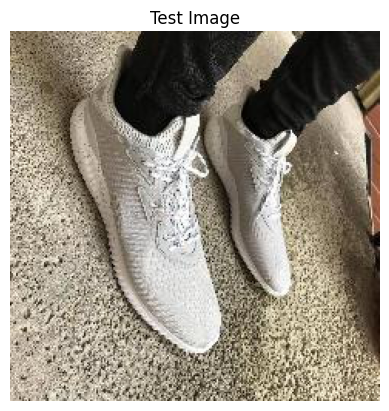

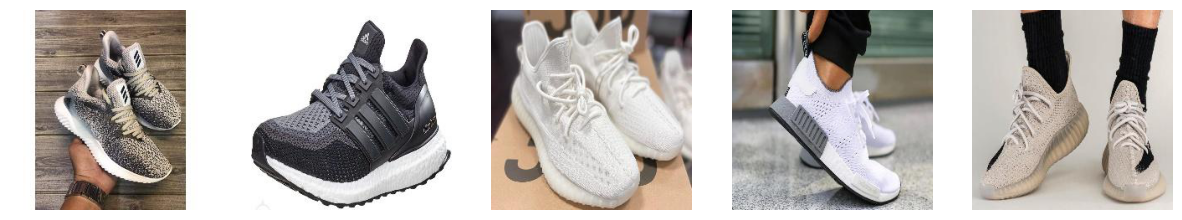

In [31]:
test_index = 65
retrieved_images = retrieve_images(test_index, nn_model_ft, dataset_train,embeddings_ft)
plt.imshow(dataset_train[test_index]["image"])
plt.title("Test Image")
plt.axis('off')
plt.show()

show_images({"train": [{"image": img} for img in retrieved_images]})